In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


Load Phase-1 & Phase-2 files

In [2]:
nasa_df = pd.read_csv("phase1_telemetry.csv")
synthetic_df = pd.read_csv("phase2_synthetic.csv")

print("NASA rows:", len(nasa_df))
print("Synthetic rows:", len(synthetic_df))


NASA rows: 1335777
Synthetic rows: 180000


Verify schema (Both must match)

In [3]:
print("NASA columns:\n", nasa_df.columns)
print("\nSynthetic columns:\n", synthetic_df.columns)


NASA columns:
 Index(['device_id', 'timestamp', 'pack_voltage', 'current', 'temperature',
       'soc', 'cycle_count', 'soh', 'event', 'source'],
      dtype='object')

Synthetic columns:
 Index(['device_id', 'timestamp', 'pack_voltage', 'current', 'temperature',
       'soc', 'cycle_count', 'soh', 'event', 'source'],
      dtype='object')


Convert timestamps properly

In [4]:
nasa_df["timestamp"] = pd.to_datetime(nasa_df["timestamp"])
synthetic_df["timestamp"] = pd.to_datetime(synthetic_df["timestamp"])


Normalize numeric columns

In [5]:
numeric_cols = [
    "pack_voltage","current","temperature",
    "soc","cycle_count","soh"
]

for col in numeric_cols:
    nasa_df[col] = pd.to_numeric(nasa_df[col], errors="coerce")
    synthetic_df[col] = pd.to_numeric(synthetic_df[col], errors="coerce")


Merge & Sort

In [6]:
unified_df = pd.concat([nasa_df, synthetic_df], ignore_index=True)

unified_df = unified_df.sort_values(
    by=["device_id", "timestamp"]
).reset_index(drop=True)

print("Total rows:", len(unified_df))
print("Total devices:", unified_df["device_id"].nunique())
print("Devices:", unified_df["device_id"].unique())


Total rows: 1515777
Total devices: 8
Devices: ['EV_RICK_01' 'EV_SCOOT_01' 'EV_TAXI_01' 'NASA_B0005' 'NASA_B0043'
 'NASA_B0045' 'NASA_B0049' 'NASA_B0054']


SoH Range Check

In [7]:
print("\nSoH Range Per Device:")
print(unified_df.groupby("device_id")["soh"].agg(["min","max"]))



SoH Range Per Device:
             min  max
device_id            
EV_RICK_01   0.7  1.0
EV_SCOOT_01  0.7  1.0
EV_TAXI_01   0.7  1.0
NASA_B0005   0.7  1.0
NASA_B0043   0.7  1.0
NASA_B0045   0.7  1.0
NASA_B0049   0.7  1.0
NASA_B0054   0.7  1.0


VISUALIZATION
SOC vs Time (Per Device)

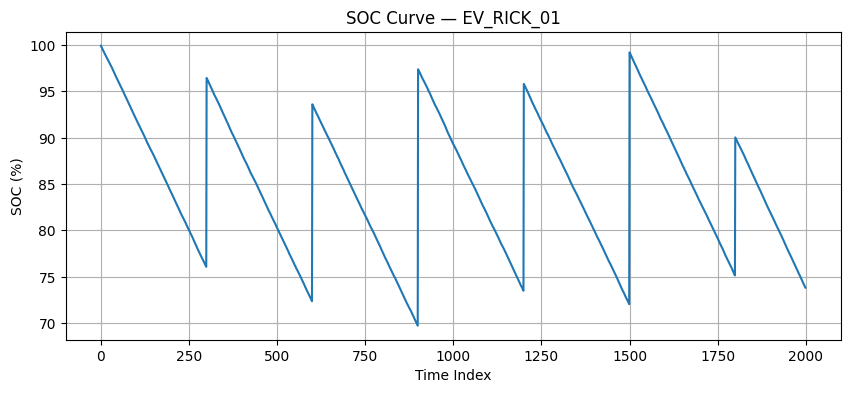

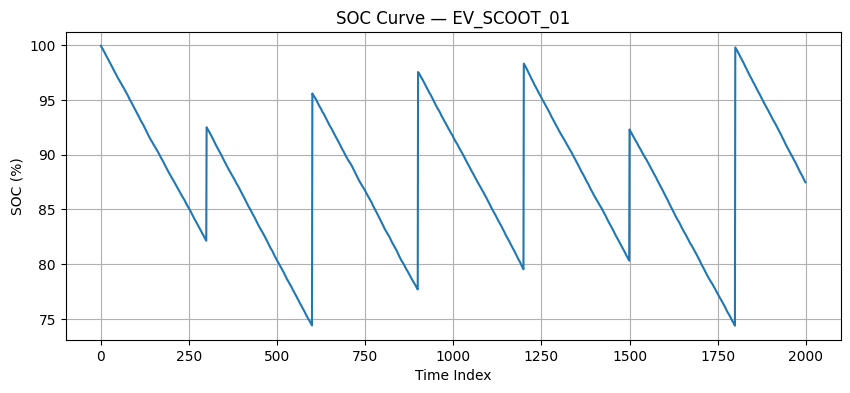

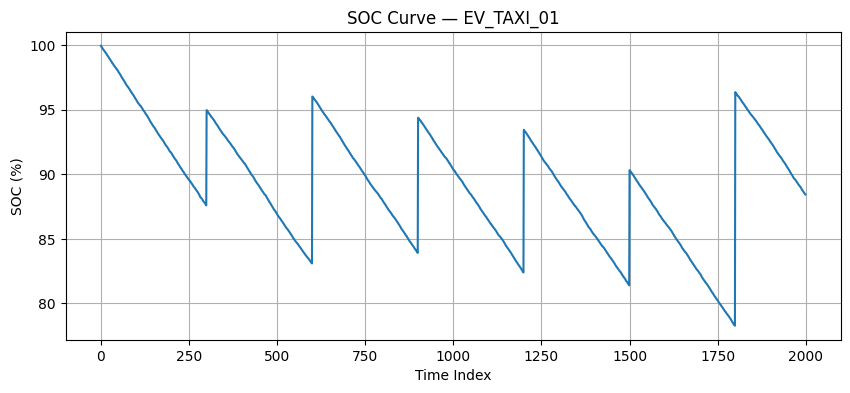

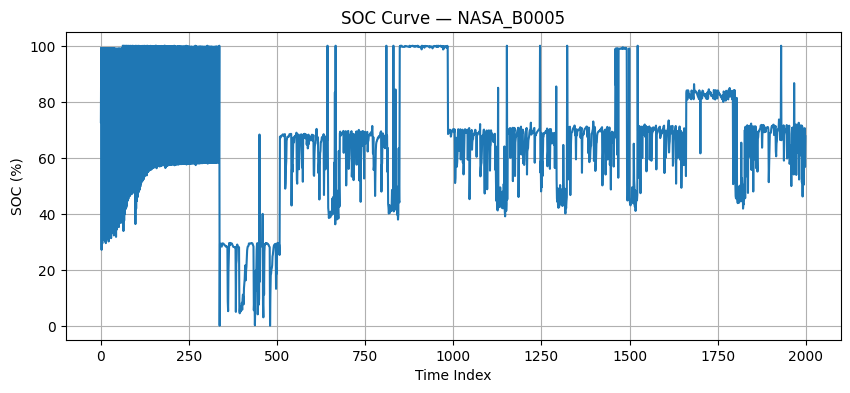

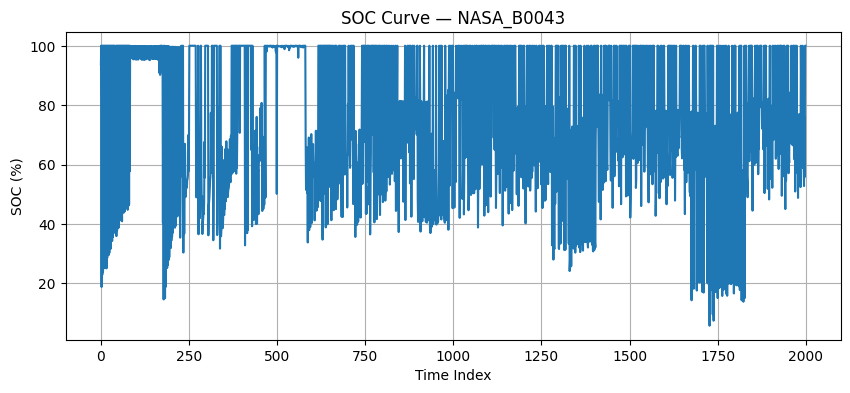

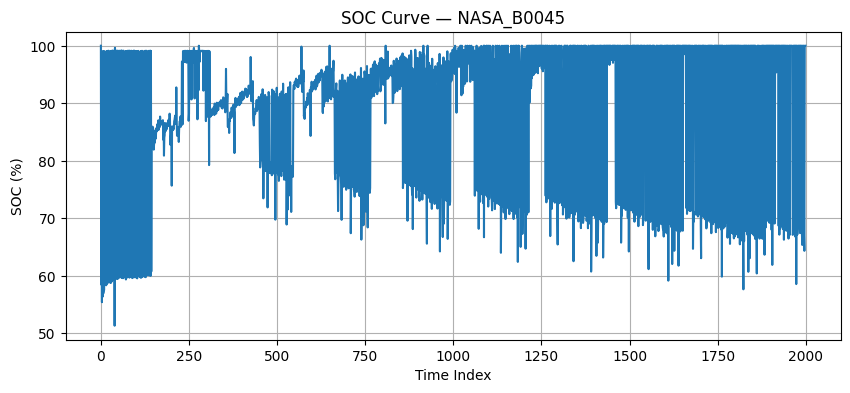

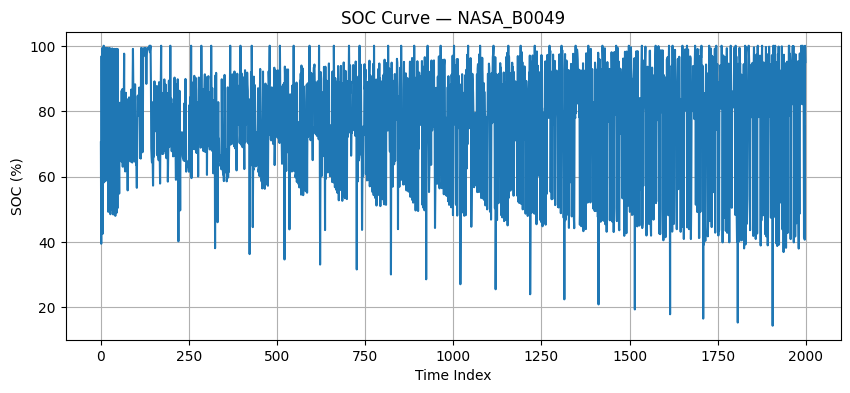

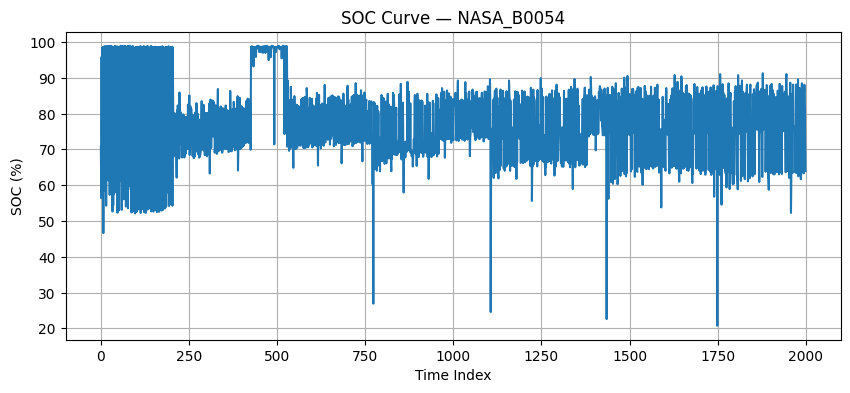

In [8]:
for dev in unified_df["device_id"].unique():

    sample = unified_df[unified_df["device_id"] == dev] \
                .head(2000) \
                .reset_index(drop=True)

    plt.figure(figsize=(10,4))
    plt.plot(sample["soc"].values)
    plt.title(f"SOC Curve — {dev}")
    plt.xlabel("Time Index")
    plt.ylabel("SOC (%)")
    plt.grid(True)
    plt.show()


SOC Distribution (NASA vs Synthetic)

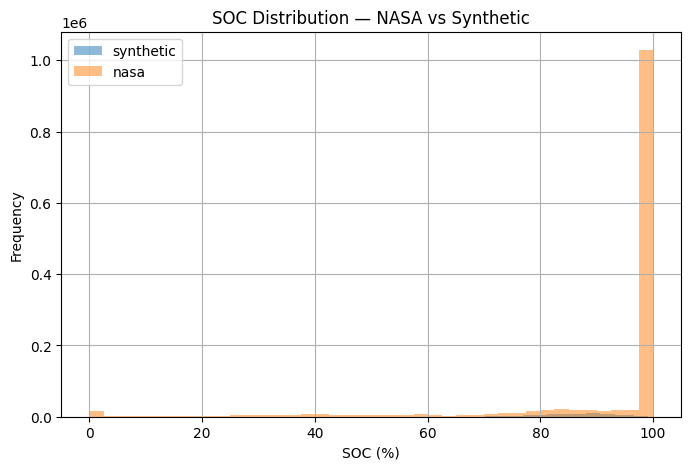

In [9]:
plt.figure(figsize=(8,5))

for src in unified_df["source"].unique():
    plt.hist(
        unified_df[unified_df["source"] == src]["soc"],
        bins=40,
        alpha=0.5,
        label=src
    )

plt.title("SOC Distribution — NASA vs Synthetic")
plt.xlabel("SOC (%)")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()


SOC vs SoH Relationship

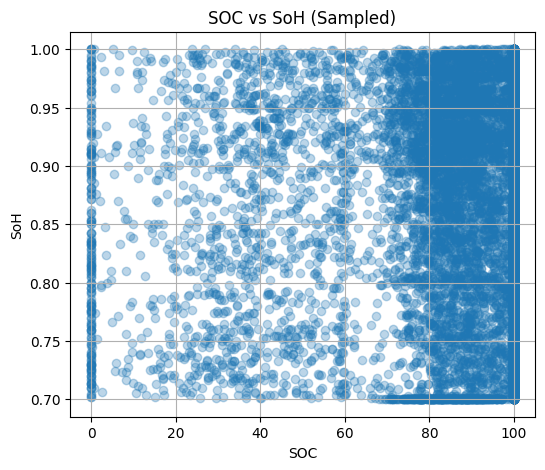

In [12]:
sample_df = unified_df.sample(20000, random_state=42)

plt.figure(figsize=(6,5))
plt.scatter(sample_df["soc"], sample_df["soh"], alpha=0.3)
plt.xlabel("SOC")
plt.ylabel("SoH")
plt.title("SOC vs SoH (Sampled)")
plt.grid(True)
plt.show()


SoH Degradation Per Device

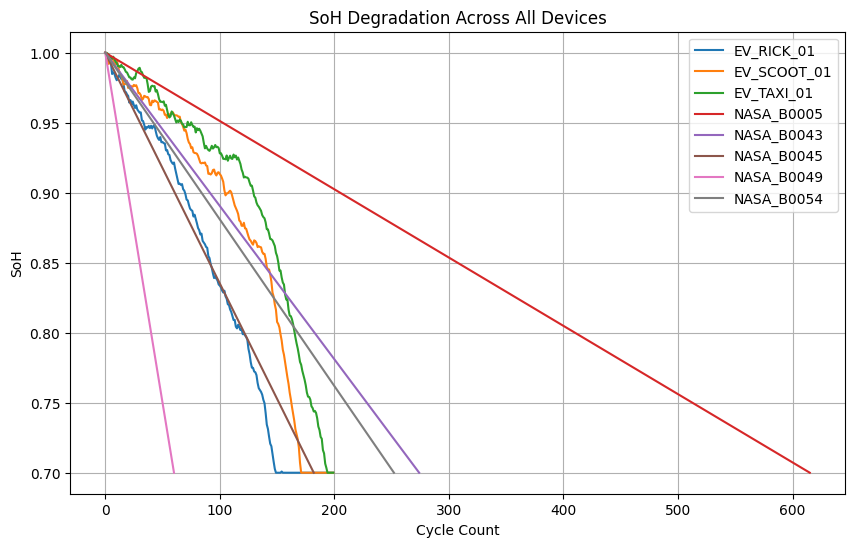

In [11]:
plt.figure(figsize=(10,6))

for dev in unified_df["device_id"].unique():
    soh_curve = unified_df[unified_df["device_id"] == dev] \
                .groupby("cycle_count")["soh"].first()
    plt.plot(soh_curve, label=dev)

plt.title("SoH Degradation Across All Devices")
plt.xlabel("Cycle Count")
plt.ylabel("SoH")
plt.legend()
plt.grid(True)
plt.show()


SoH Distribution (NASA vs Synthetic)

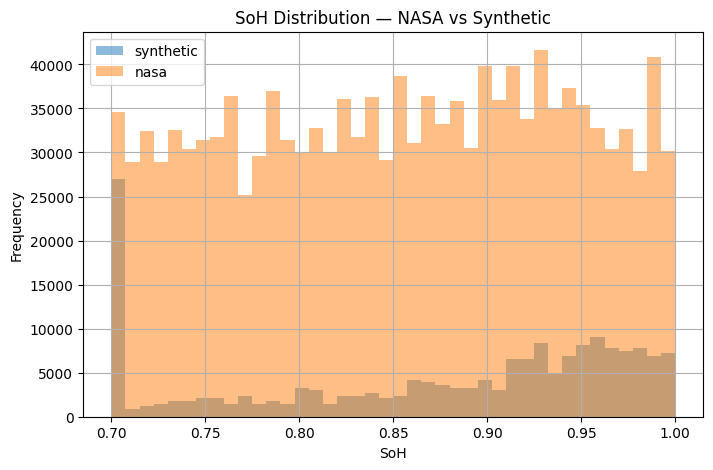

In [13]:
plt.figure(figsize=(8,5))

for src in unified_df["source"].unique():
    plt.hist(
        unified_df[unified_df["source"] == src]["soh"],
        bins=40,
        alpha=0.5,
        label=src
    )

plt.title("SoH Distribution — NASA vs Synthetic")
plt.xlabel("SoH")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()


Final Cleaning

In [14]:
unified_df = unified_df.dropna()

print("Final rows after cleaning:", len(unified_df))


Final rows after cleaning: 1515717


Save Phase 3 Output

In [15]:
unified_df.to_csv("phase3_unified.csv", index=False)

unified_df.to_json(
    "phase3_unified.jsonl",
    orient="records",
    lines=True
)

print("Phase 3 unified dataset saved successfully")


Phase 3 unified dataset saved successfully
